## Choose if you want to use the full dataset or a 10k subset, and download it

In [1]:
FULL_DATASET = False

In [2]:
# Then download it
import os
data_path = "movie_subset"
if not FULL_DATASET:
    # My 10k subset
    !git clone https://huggingface.co/datasets/sisimone/movie_subset {data_path} &> /dev/null
else:
    # 761k movies (22.5GB) (~12min):
    try:
        from google.colab import userdata
        os.environ['KAGGLE_USERNAME'] = userdata.get("KAGGLE_USERNAME")
        os.environ['KAGGLE_KEY'] = userdata.get("KAGGLE_KEY")
        !kaggle datasets download -d "gsimonx37/letterboxd" -p {data_path} --unzip
    except:
        raise Exception("Kaggle username and key are needed to access the dataset, either as colab secrets or hardcoded strings")

## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import plotly.express

np.set_printoptions(precision=3, suppress=True)

AUTOTUNE = tf.data.AUTOTUNE

## Parameters definition

In [4]:
if FULL_DATASET:
    EPOCHS = 30
    BATCH_SIZE = 64
else:
    EPOCHS = 17
    BATCH_SIZE = 16
img_height = 128    #Resizing of the images
img_width = 128
val_split = .2      #Percentage split for the validation set
test_split = .1     #Percentage split for the test set

# Path variables setting
posters_dir = "posters"
images_dir = os.path.join(data_path, posters_dir)
genres_filepath = os.path.join(data_path,"genres.csv")

In [5]:
# Reading of the csv file containing the labels
genres_df = pd.read_csv(genres_filepath)

# We have to drop the movies without poster
if FULL_DATASET:
    genres_df = genres_df[genres_df["genre"] != "TV Movie"] # Exclude TV Movie genre
    poster_ids = [int(i.split(".")[0]) for i in os.listdir(images_dir)]
    genres_df = genres_df[genres_df['id'].isin(poster_ids)]

# Setting the labels array (later used to build the multi-hot arrays)
unique_genres = sorted(genres_df["genre"].unique())
# The data structure that associates every movie poster image (the feature) to its genre (the label)
genre_mapping = genres_df.groupby('id')['genre'].apply(list).to_dict()

## Labels distribution plotting

In [6]:
plotly.express.histogram(data_frame=genres_df, x='genre', title='Count of genres occurrencies')

In [7]:
# To show that the number of movies with just one genre associated to them is the same for every genre (or at most the maximum available for the dataset)
genre_counts_per_id = genres_df.groupby('id')['genre'].nunique()

single_genre_ids = genre_counts_per_id[genre_counts_per_id == 1].index

df_single_genre = genres_df[genres_df['id'].isin(single_genre_ids)]

genre_counts_single = df_single_genre['genre'].value_counts()
print(genre_counts_single)

fig = plotly.express.bar(genre_counts_single,
             x=genre_counts_single.index,
             y=genre_counts_single.values,
             title="Number of movies with single genre, per genre",
             labels={"x": "genre", "y": "movie count"})

fig.update_layout(xaxis_title_standoff=0) #remove space
fig.show()

genre
Drama              388
Comedy             388
Horror             388
Western            388
Science Fiction    388
Mystery            388
Music              388
Thriller           388
Documentary        388
Action             388
Crime              388
Animation          388
Fantasy            388
Romance            388
War                388
Family             388
History            388
Adventure          388
Name: count, dtype: int64


In [8]:
# Since the full dataset is very unbalanced among the genres, I will remove half of the movies that have either only "Drama" or only "Documentary", so i will not count the ones that have multiple genres (in which also drama or doc appear)
if FULL_DATASET:
    import random
    drama_keys = [k for k, v in genre_mapping.items() if v == ['Drama']]
    doc_keys = [k for k, v in genre_mapping.items() if v == ['Documentary']]

    # Randomly select half of the drama-only keys to remove
    drama_num_to_remove = len(drama_keys) // 2
    doc_num_to_remove = len(doc_keys) // 2
    drama_keys_to_remove = set(random.sample(drama_keys, drama_num_to_remove))
    doc_keys_to_remove = set(random.sample(doc_keys, doc_num_to_remove))

    # Remove in-place
    for key in drama_keys_to_remove:
        del genre_mapping[key]
    for key in doc_keys_to_remove:
        del genre_mapping[key]

    print("Removed: ",drama_num_to_remove," Drama-only movies")
    print("Removed: ",doc_num_to_remove," Documentary-only movies")

In [9]:
# Setting the sizes for the dataset
dataset_size = len(genre_mapping)
val_size = int(dataset_size * val_split)
test_size = int(dataset_size * test_split)

## Data processing functions

In [10]:
def multi_hot_encode(genres):
    one_hot = tf.zeros(len(unique_genres), dtype=tf.int32)
    def update_one_hot(genre):
        index = unique_genres.index(genre)
        one_hot_update = tf.tensor_scatter_nd_update(
            one_hot, indices=[[index]], updates=[1]
        )
        return one_hot_update
    for genre in genres:
        if genre in unique_genres:
            one_hot = update_one_hot(genre)
    return one_hot

def get_label(file_path):
    pic_id = tf.strings.to_number(tf.strings.split(file_path, ".")[0], tf.int32)
    def map_genres(id):
        genres_list = genre_mapping.get(id.numpy(), [])
        return multi_hot_encode(genres_list)
    label = tf.py_function(map_genres, [pic_id], tf.int32)
    label.set_shape([len(unique_genres)])
    return label

# Image processing (reading and decoding, resizing and normalizing are embedded layers in the model)
def decode_img(file_path):
    full_path = tf.strings.join([images_dir, file_path], separator="/")
    img = tf.io.read_file(full_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    return img

def get_image_and_label(file_path):
    img = decode_img(file_path)
    label = get_label(file_path)
    return img, label

# Some dataset preprocessing for efficiency
def configure_for_performance(ds):
    if not FULL_DATASET:
        ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

## Data preprocessing

In [11]:
images_list_fullpath = os.listdir(images_dir)
images_list_fullpath_ds = tf.data.Dataset.from_tensor_slices(images_list_fullpath)

# Shuffle before splitting
images_list_fullpath_ds = images_list_fullpath_ds.shuffle(buffer_size=len(images_list_fullpath))

# Mapping the image and label processing
preproc_ds = images_list_fullpath_ds.map(get_image_and_label, num_parallel_calls=AUTOTUNE)

# SPLITTING: TRAIN, VALIDATION AND TEST
train_ds = preproc_ds.skip(val_size+test_size)
val_ds = preproc_ds.skip(test_size).take(val_size)
test_ds = preproc_ds.take(test_size)

# Optimizing
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

## Training plotting functions

In [12]:
def plot_loss(history, ep_range):
    plt.subplot(1, 2, 1)
    plt.plot(ep_range, history.history['loss'], label='Training Loss')
    plt.plot(ep_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Loss')

def plot_accuracy(history, ep_range):
    plt.subplot(1, 2, 2)
    plt.plot(ep_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(ep_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.title('Accuracy')

def plot_loss_and_accuracy(history):
    plt.figure(figsize=(10, 4))
    ep_range = range(len(history.history['loss']))
    plot_loss(history, ep_range)
    plot_accuracy(history, ep_range)
    plt.legend()
    plt.show()

def save_plot_to_disk(file_name, history):
    plt.figure(figsize=(10, 4))
    ep_range = range(len(history.history['loss']))
    plot_loss(history, ep_range)
    plot_accuracy(history, ep_range)
    plt.legend()
    plt.savefig(file_name+".png")

## Model definition

In [13]:
def new_model():
    model = Sequential([
        layers.Input(shape=(img_height,img_width,3)),
        layers.Resizing(img_height,img_width),
        layers.Rescaling(scale=1./255),
        layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(filters=32, kernel_size=6, padding="same", activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2),
        layers.Conv2D(filters=64, kernel_size=6, padding="same", activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(unique_genres), activation="sigmoid")
    ])
    model.compile(optimizer='adam',
        loss="binary_crossentropy",
        metrics=['accuracy']
    )
    return model

# Create a new model from scratch
model = new_model()
# Or restore from a saved checkpoint
#model = keras.models.load_model("movie_genre_model_ckp.keras")


callbacks = []

if FULL_DATASET:
    # Checkpoints implementation to recover training
    checkpoint_dir = "./training_checkpoints"
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    callbacks.append(
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/movie_genre_model_{epoch}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0,
        )
    )
else:
    # Early stopping (to prevent overfitting)
    callbacks.append(
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            min_delta=5e-3,
            patience=2,
            verbose=1,
        )
    )

# Show the model graphs

model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, rankdir="LR")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,291,890 (16.37 MB)

 Trainable params: 4,291,890 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    train_ds,
    validation_data= val_ds,
    epochs= EPOCHS,
    verbose= 1,
    callbacks= callbacks
)

Epoch 1/17
437/437 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - accuracy: 0.0874 - loss: 0.3199 - val_accuracy: 0.1308 - val_loss: 0.2803
Epoch 2/17
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1156 - loss: 0.2904 - val_accuracy: 0.1122 - val_loss: 0.2769
Epoch 3/17
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1165 - loss: 0.2840 - val_accuracy: 0.1498 - val_loss: 0.2733
Epoch 4/17
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1323 - loss: 0.2800 - val_accuracy: 0.1298 - val_loss: 0.2701
Epoch 5/17
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1480 - loss: 0.2758 - val_accuracy: 0.2009 - val_loss: 0.2642
Epoch 6/17
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1656 - loss: 0.2723 - val_accuracy: 0.2169 - val_loss: 0.2571
Epoch 7/17
437/437 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1935 - loss: 0.2648 - val_accuracy: 0.2550 - val_loss: 0.2497
Epoch 8/17
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2295 - loss: 0.2533 - val_ac

## Evaluate and plot the model training accuracy and loss

In [15]:
result = model.evaluate(test_ds)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5912 - loss: 0.1697


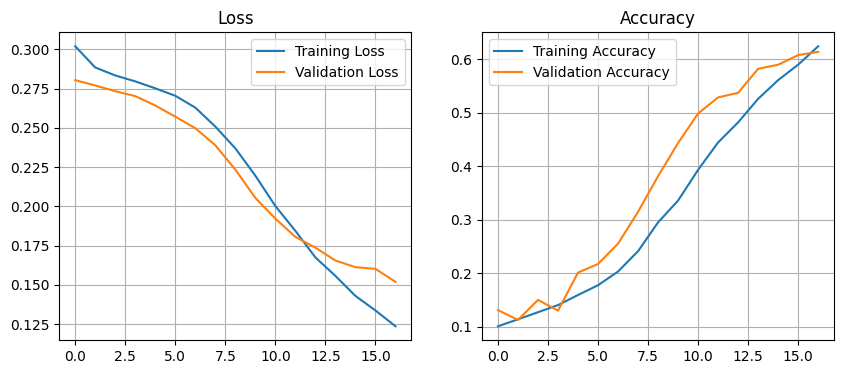

In [16]:
plot_loss_and_accuracy(history)

---
# Test the model with an image from the web
---

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


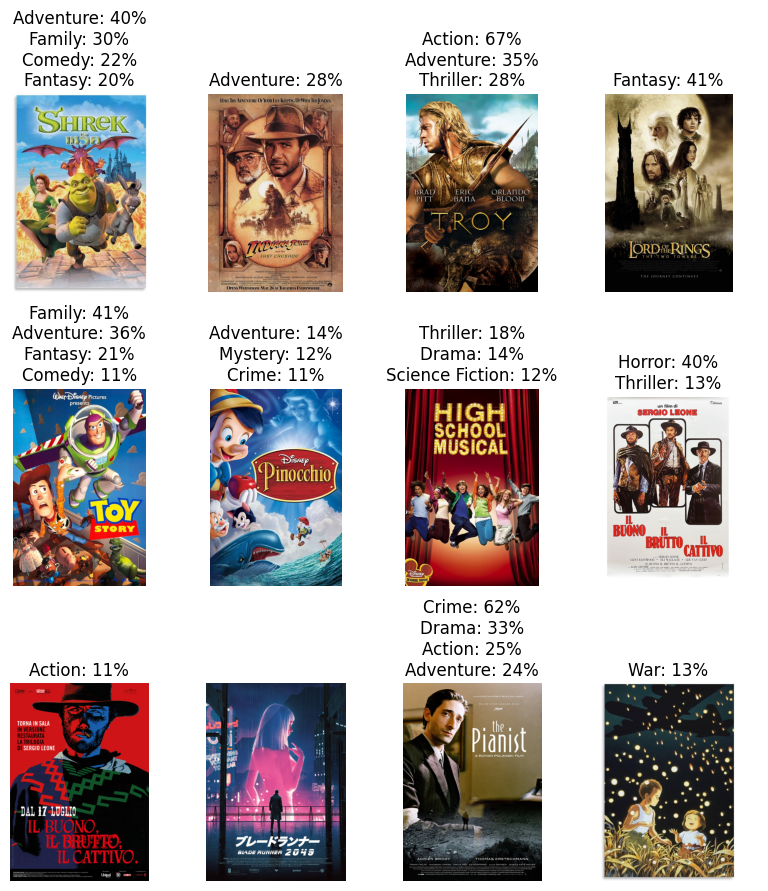

In [17]:
import requests
import matplotlib.image as mpimg
from matplotlib import gridspec

urls = [
    "https://m.media-amazon.com/images/I/71oilCC6J+L._AC_UF894,1000_QL80_.jpg", #shrek
    "https://m.media-amazon.com/images/I/71agXxNrnOL._AC_UF1000,1000_QL80_.jpg", #indiana jones
    "https://i.ebayimg.com/images/g/yPEAAOSwNmdg3W0Z/s-l1200.jpg", #troy
    "https://i.ebayimg.com/images/g/GpMAAOSwn~5fagg~/s-l1200.jpg", #lotr
    "https://m.media-amazon.com/images/I/71aBLaC4TzL._AC_UF894,1000_QL80_.jpg", #toy story
    "https://lumiere-a.akamaihd.net/v1/images/p_pinocchio_19879_d6304938.jpeg", #pinocchio
    "https://m.media-amazon.com/images/I/71BVUS-F2EL._AC_UF1000,1000_QL80_.jpg", #high school musical
    "https://www.goposter.it/1490-thickbox_default/film-poster-il-buono-il-brutto-il-cattivo-sergio-leone-70x100-cm.jpg", #il buono il brutto il cattivo
    "https://pad.mymovies.it/filmclub/2002/08/283/locandina.jpg", #il buono il brutto il cattivo
    "https://alternativemovieposters.com/wp-content/uploads/2022/11/Matt-Ferguson_BladeRunner.jpg", #blade runner
    "https://image.tmdb.org/t/p/original/ryFXgaymUOFEwTpuqp4Osi9dRxr.jpg", #the pianist
    "https://m.media-amazon.com/images/I/61DaraQRyHL._AC_UF1000,1000_QL80_.jpg", #grave of the fireflies
]

n_cols = 4
n_rows = -(-len(urls) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 3 * n_rows))
axes = axes.flatten()

# Process each image and plot in the grid
for idx, url in enumerate(urls):
    response = requests.get(url, stream=True).raw
    img = mpimg.imread(response, format='jpeg')

    # Preprocess
    preprocessed_image = tf.io.decode_image(requests.get(url).content, channels=3)
    processed_image = tf.expand_dims(preprocessed_image, axis=0)

    # Predict genres
    predictions = model.predict(processed_image)
    sorted_indices = np.argsort(predictions[0])[::-1]
    sorted_labels = [(unique_genres[i], predictions[0][i]) for i in sorted_indices]

    # I choose to show only above .1 threshold for predictions
    filtered_labels = [(label, prob) for label, prob in sorted_labels if prob >= 0.1]

    genres_text = "\n".join([f"{label}: {prob * 100:.0f}%" for label, prob in filtered_labels])

    # Plot
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(genres_text, fontsize=12)

for j in range(len(urls), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()